### Instrucciones

El conjunto de datos a explorar es un set de datos de recaudaciones de
películas de cine. En el siguiente enlace se pueden obtener los datos, así
como el detalle del contenido de estos: Movie Industry | Kaggle 

* Quedan excluidas del desafío las variables: director, star y writer

#### Cuestiones planteadas

En la presentación se espera que des recomendaciones de qué tipo de
películas debería hacer una productora de cine que quiere maximizar el
beneficio de sus producciones. A modo de ejemplo, estas son algunas de las
preguntas que se puede plantear la compañía en este sentido:

• ¿En qué género debería enfocarme?

• ¿Qué tan importante es producir una buena película (rating IMDB alto)
para obtener muchos ingresos?

• ¿Es mejor producir una película para todos los públicos? ¿O una dirigida
sólo al público adulto?

• ...

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
# Reading data

raw_data = pd.DataFrame(pd.read_csv('../raw_data/movies.csv', encoding = 'iso-8859-1'))

In [3]:
raw_data.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [4]:
# Dropping director, star and writer
data = raw_data.drop(columns =['director', 'star', 'writer'])


In [5]:
data.head()

,budget,company,country,genre,gross,name,rating,released,runtime,score,votes,year
0,8000000.0,Columbia Pictures Corporation,USA,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,299174,1986
1,6000000.0,Paramount Pictures,USA,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,264740,1986
2,15000000.0,Paramount Pictures,USA,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,236909,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,540152,1986
4,9000000.0,Walt Disney Pictures,USA,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,36636,1986


### Data Cleaning

In [6]:
#Checking for duplicates

len(data) # Check number of rows before removing duplicates
data = data.drop_duplicates() # Remove duplicates
len(data)# Check new number of rows

6820

In [7]:
# Checking for null values 

data.isnull().sum().sort_values(ascending=False)/len(data) #NaN percentage for each column

budget      0.0
company     0.0
country     0.0
genre       0.0
gross       0.0
name        0.0
rating      0.0
released    0.0
runtime     0.0
score       0.0
votes       0.0
year        0.0
dtype: float64

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version

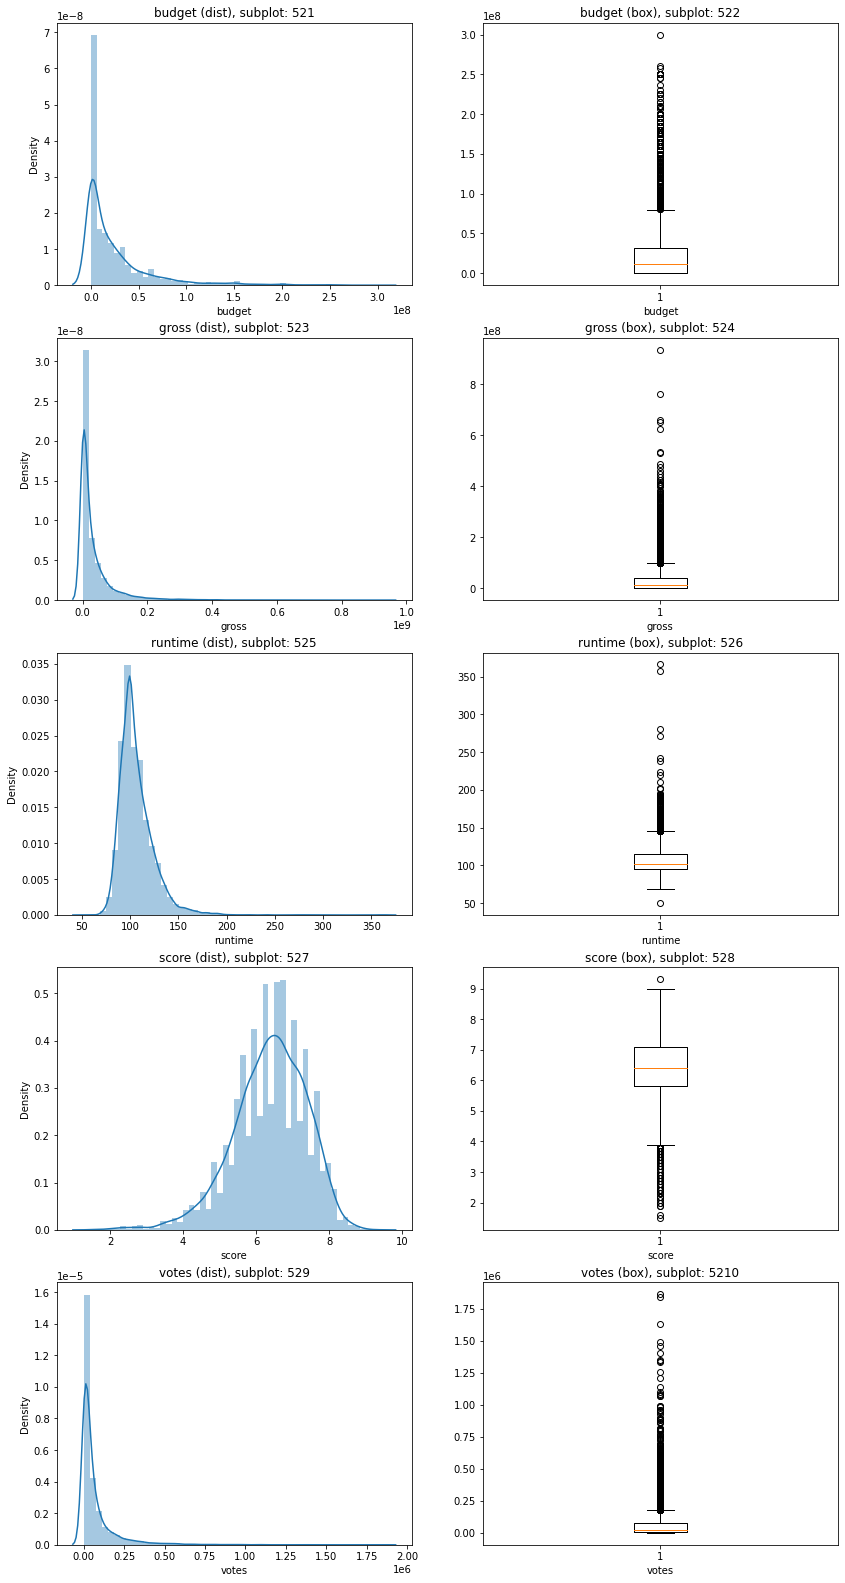

In [8]:
# Plotting and checking for false outliers

#  Numerical Data
data_NUM = ['budget', 'gross', 'runtime', 'score', 'votes']

#  plot Numerical Data
a = 5  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,28))

for i in data_NUM:
    plt.subplot(a, b, c)
    plt.title('{} (dist), subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.distplot(data[i])
    c = c + 1

    plt.subplot(a, b, c)
    plt.title('{} (box), subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    plt.boxplot(x = data[i])
    c = c + 1

In [9]:
# Counting 0 values in budget

data['budget'].value_counts().sort_index(ascending=True)

0.0            2182
6000.0            1
7000.0            2
15000.0           2
20000.0           1
               ... 
245000000.0       2
250000000.0       8
258000000.0       1
260000000.0       1
300000000.0       1
Name: budget, Length: 351, dtype: int64

In [10]:
# Creating a second data frame to evaluate profit (revenue - cost)

# Keeping rows that have a positive budget, since profit without budget would be just revenue.

data_profit = pd.DataFrame(data[data['budget'] > 0])

# Creating profit column = gross - budget

data_profit['profit'] = data_profit['gross'] - data_profit['budget']

data_profit

,budget,company,country,genre,gross,name,rating,released,runtime,score,votes,year,profit
0,8000000.0,Columbia Pictures Corporation,USA,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,299174,1986,44287414.0
1,6000000.0,Paramount Pictures,USA,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,264740,1986,64136369.0
2,15000000.0,Paramount Pictures,USA,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,236909,1986,164800601.0
3,18500000.0,Twentieth Century Fox Film Corporation,USA,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,540152,1986,66660248.0
4,9000000.0,Walt Disney Pictures,USA,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,36636,1986,9564613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6808,3000000.0,Westerly Films,Ireland,Comedy,14013564.0,Love & Friendship,PG,2016-06-03,90,6.5,17862,2016,11013564.0
6809,3800000.0,Sycamore Pictures,USA,Comedy,1016872.0,The Hollars,PG-13,2016-08-26,88,6.5,7227,2016,-2783128.0
6811,8500000.0,CBS Films,USA,Animation,19985196.0,Middle School: The Worst Years of My Life,PG,2016-10-07,92,6.1,4556,2016,11485196.0
6814,20000000.0,LD Entertainment,USA,Action,36874745.0,Risen,PG-13,2016-02-19,107,6.3,19084,2016,16874745.0


In [11]:
# Creating high_score column (Score >= 7.5)

def high_score(row):
    if row['score'] >= 7.5:
        return 1
    else:
        return 0 

raw_data['high_score'] = raw_data.apply (lambda row: high_score(row), axis=1)
data['high_score'] = data.apply (lambda row: high_score(row), axis=1)

# Replicate process for profit dataframe
data_profit['high_score'] = data_profit.apply (lambda row: high_score(row), axis=1) 

In [12]:
data['high_score'].value_counts()

0    5888
1     932
Name: high_score, dtype: int64

In [13]:
# Scaling numeric independent variables 

# Defining numeric independent variables
data_NUM_X = ['budget', 'runtime', 'score', 'votes']

scaler = MinMaxScaler() # Instanciate MinMaxScaler


for i in data_NUM_X:
    scaler.fit(data[[i]]) # Fit scaler to data
    data[i] = scaler.transform(data[[i]]) # Use scaler to transform data
    # Replicate process for profit dataframe
    scaler.fit(data_profit[[i]]) # Fit scaler to data
    data_profit[i] = scaler.transform(data_profit[[i]]) # Use scaler to transform data



### Feature Engineering

In [14]:
# Checking number of unique values for categorical variables

data_CAT = ['company', 'country', 'genre', 'rating']
for i in data_CAT:
    print(f'{i} has {data[i].nunique()} unique values.')


company has 2179 unique values.
country has 57 unique values.
genre has 17 unique values.
rating has 13 unique values.


In [63]:
# Encoding Genre 

genre_encoding = pd.DataFrame(data[['genre']])
genre_encoding = pd.get_dummies(genre_encoding)
# Replicate process for profit dataframe
genre_encoding_profit = pd.DataFrame(data_profit[['genre']])
genre_encoding_profit = pd.get_dummies(genre_encoding_profit)

# Encoding Rating

rating_encoding = pd.DataFrame(data[['rating']])
rating_encoding = pd.get_dummies(rating_encoding)
# Replicate process for profit dataframe
rating_encoding_profit = pd.DataFrame(data_profit[['rating']])
rating_encoding_profit = pd.get_dummies(rating_encoding_profit)

In [65]:
genre_encoding

,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6816,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6817,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6818,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [64]:
rating_encoding

,rating_B,rating_B15,rating_G,rating_NC-17,rating_NOT RATED,rating_Not specified,rating_PG,rating_PG-13,rating_R,rating_TV-14,rating_TV-MA,rating_TV-PG,rating_UNRATED
0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,0,0,0,0,0,0,0,0,1,0,0,0,0
6816,0,0,0,0,0,0,0,1,0,0,0,0,0
6817,0,0,0,0,0,0,0,0,1,0,0,0,0
6818,0,0,0,0,0,0,0,0,1,0,0,0,0


In [17]:
# Create adult_movie column

def adult_rated(row):
    if row['rating'] == 'R':
        return 1
#     elif row['rating'] == 'NC-17':
#         return 1
    else:
        return 0 

data['adult_movie'] = data.apply (lambda row: adult_rated(row), axis=1)  

# Replicate process for profit dataframe

data_profit['adult_movie'] = data_profit.apply (lambda row: adult_rated(row), axis=1) 

In [18]:
# Create general_movie column
def general_rated(row):
    if row['rating'] == 'G':
        return 1
    else:
        return 0 

data['general_movie'] = data.apply (lambda row: general_rated(row), axis=1)

# Replicate process for profit dataframe
data_profit['general_movie'] = data_profit.apply (lambda row: general_rated(row), axis=1) 

In [93]:
# Encoding company

company_encoding = pd.DataFrame(data[['company']])

# Creating list with 25 most frequent companies

company_encoding.company.value_counts().sort_values(ascending=False).head(25)
top_25_companies = [x for x in company_encoding.company.value_counts().sort_values(ascending=False).head(25).index]

# Creating binary columns for top 25 companies
for i in top_25_companies:
    company_encoding[i] = np.where(company_encoding.company == i, 1, 0)
    
    
# Replicating process for profit dataframe

company_encoding_profit = pd.DataFrame(data_profit[['company']])

# Creating list with 25 most frequent companies

company_encoding_profit.company.value_counts().sort_values(ascending=False).head(25)
top_25_companies_profit = [x for x in company_encoding_profit.company.value_counts().sort_values(ascending=False).head(25).index]

# Creating binary columns for top 25 companies
for i in top_25_companies_profit:
    company_encoding_profit[i] = np.where(company_encoding_profit.company == i, 1, 0)


In [97]:
# Encoding countries

country_encoding = pd.DataFrame(data[['country']])

# Creating list with 15 most frequent countries

country_encoding.country.value_counts().sort_values(ascending=False).head(15)
top_15_countries = [x for x in country_encoding.country.value_counts().sort_values(ascending=False).head(15).index]

# Creating binary columns for top 15 countries
for i in top_15_countries:
    country_encoding[i] = np.where(country_encoding.country == i, 1, 0)
    
# Replicating process for profit dataframe

country_encoding_profit = pd.DataFrame(data_profit[['country']])

# Creating list with 15 most frequent countries

country_encoding_profit.country.value_counts().sort_values(ascending=False).head(15)
top_15_countries_profit = [x for x in country_encoding_profit.country.value_counts().sort_values(ascending=False).head(15).index]

# Creating binary columns for top 15 countries
for i in top_15_countries:
    country_encoding_profit[i] = np.where(country_encoding_profit.country == i, 1, 0)

### Feature Selection

In [21]:
# Evaluating Pearson Correlation between features

corr = data.corr() # Create correlation matrix
corr

,budget,gross,runtime,score,votes,year,high_score,adult_movie,general_movie
budget,1.000000,0.712196,0.268226,0.042145,0.503924,0.291009,0.018257,-0.240115,0.051912
gross,0.712196,1.000000,0.224579,0.165693,0.662457,0.191548,0.137533,-0.231997,0.074646
runtime,0.268226,0.224579,1.000000,0.395343,0.317399,0.087639,0.309009,0.040636,-0.119022
score,0.042145,0.165693,0.395343,1.000000,0.393607,0.105276,0.567589,0.077665,0.009351
votes,0.503924,0.662457,0.317399,0.393607,1.000000,0.229304,0.402893,-0.032903,0.005473
year,0.291009,0.191548,0.087639,0.105276,0.229304,1.000000,0.026286,-0.037576,-0.049677
high_score,0.018257,0.137533,0.309009,0.567589,0.402893,0.026286,1.000000,0.010638,0.011498
adult_movie,-0.240115,-0.231997,0.040636,0.077665,-0.032903,-0.037576,0.010638,1.000000,-0.147641
general_movie,0.051912,0.074646,-0.119022,0.009351,0.005473,-0.049677,0.011498,-0.147641,1.000000


In [22]:
# Evaluating R Squared
corr**2

,budget,gross,runtime,score,votes,year,high_score,adult_movie,general_movie
budget,1.000000,0.507222,0.071945,0.001776,0.253939,0.084686,0.000333,0.057655,0.002695
gross,0.507222,1.000000,0.050436,0.027454,0.438849,0.036690,0.018915,0.053822,0.005572
runtime,0.071945,0.050436,1.000000,0.156296,0.100742,0.007681,0.095487,0.001651,0.014166
score,0.001776,0.027454,0.156296,1.000000,0.154927,0.011083,0.322158,0.006032,0.000087
votes,0.253939,0.438849,0.100742,0.154927,1.000000,0.052580,0.162323,0.001083,0.000030
year,0.084686,0.036690,0.007681,0.011083,0.052580,1.000000,0.000691,0.001412,0.002468
high_score,0.000333,0.018915,0.095487,0.322158,0.162323,0.000691,1.000000,0.000113,0.000132
adult_movie,0.057655,0.053822,0.001651,0.006032,0.001083,0.001412,0.000113,1.000000,0.021798
general_movie,0.002695,0.005572,0.014166,0.000087,0.000030,0.002468,0.000132,0.021798,1.000000


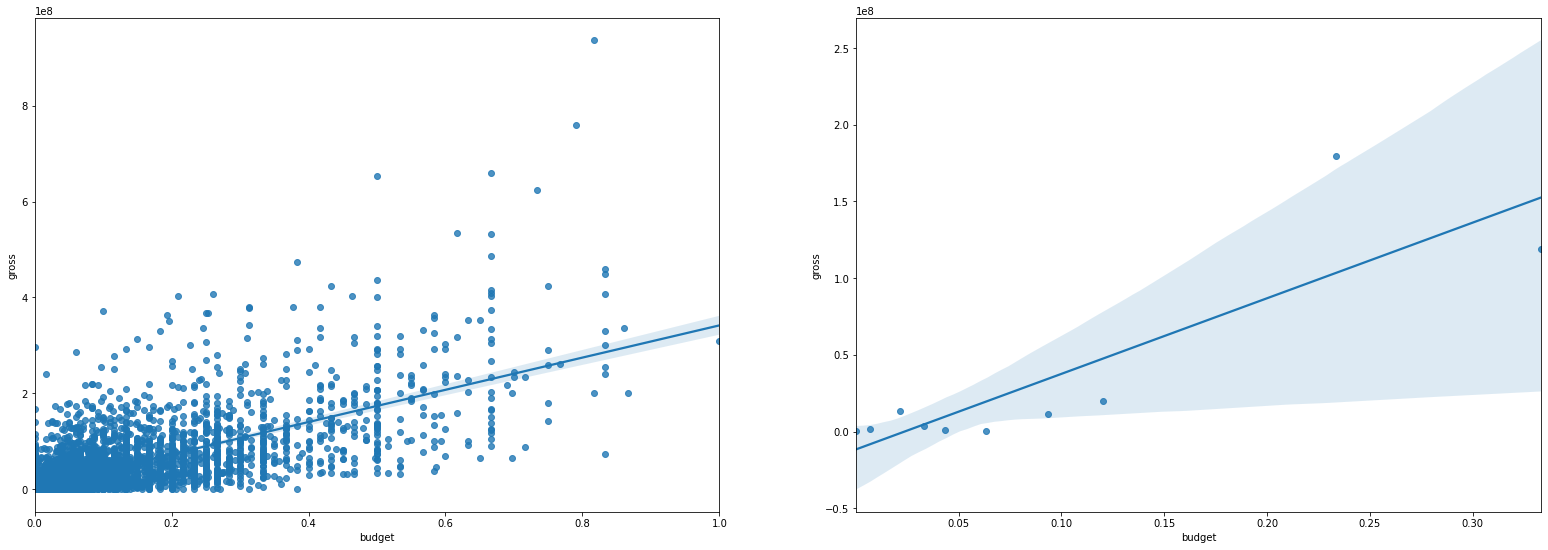

In [23]:
# Plotting relationship between gross and budget

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='budget', y='gross', data=data, ci=95)b
plt.subplot(2,2,2)
sns.regplot(x='budget', y='gross', data=data.sample(10, random_state=6), ci=95);

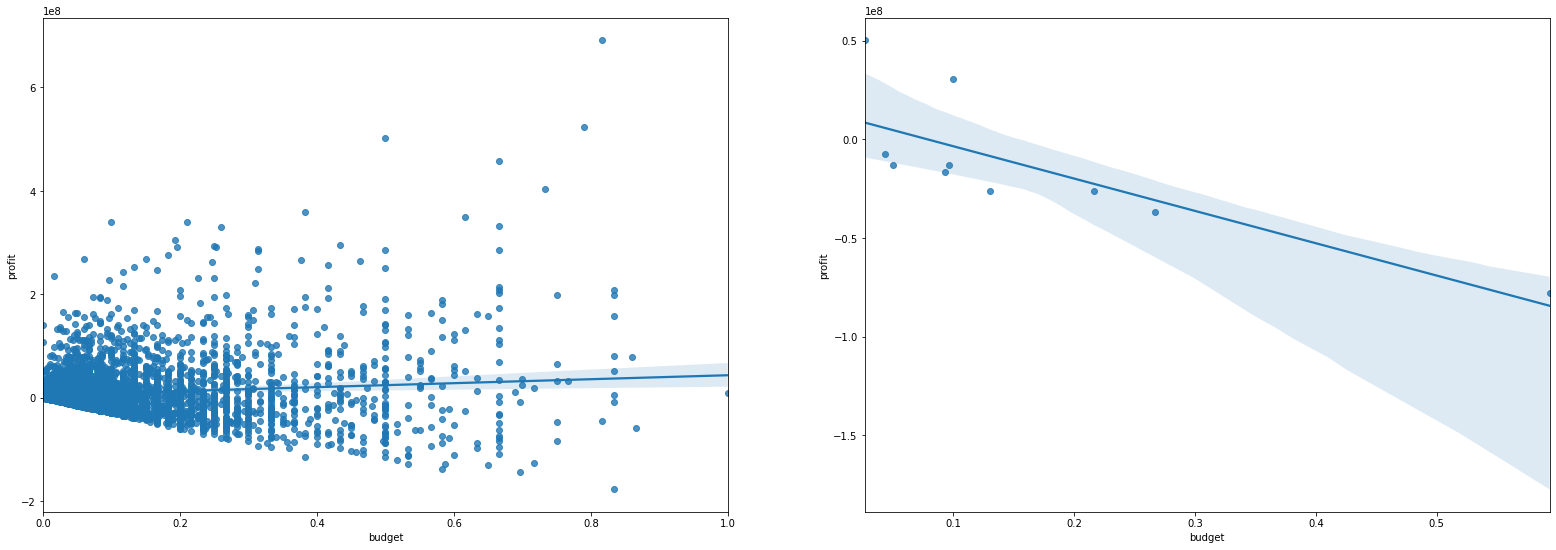

In [140]:
# Plotting relationship between profit and budget

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='budget', y='profit', data=data_profit, ci=95)
plt.subplot(2,2,2)
sns.regplot(x='budget', y='profit', data=data_profit.sample(10, random_state=6), ci=95);

<AxesSubplot:xlabel='votes', ylabel='profit'>

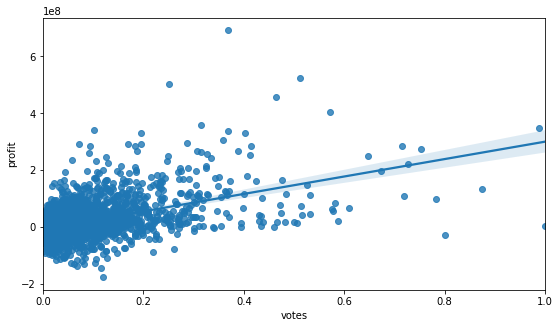

In [145]:
# Plotting relationship between profit and votes

plt.figure(figsize=(9,5))
# plt.subplot(2,2,1)
sns.regplot(x='votes', y='profit', data=data_profit, ci=95)
# plt.subplot(2,2,2)
# sns.regplot(x='votes', y='profit', data=data_profit.sample(10, random_state=6), ci=95);

In [24]:
# Ranking features by correlation

corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(20)

,feature_1,feature_2,correlation
9,gross,budget,0.712196
1,budget,gross,0.712196
13,gross,votes,0.662457
37,votes,gross,0.662457
33,score,high_score,0.567589
57,high_score,score,0.567589
36,votes,budget,0.503924
4,budget,votes,0.503924
42,votes,high_score,0.402893
58,high_score,votes,0.402893


In [25]:
corr_df.tail(20)

,feature_1,feature_2,correlation
69,adult_movie,high_score,0.010638
61,high_score,adult_movie,0.010638
75,general_movie,score,0.009351
35,score,general_movie,0.009351
76,general_movie,votes,0.005473
44,votes,general_movie,0.005473
67,adult_movie,votes,-0.032903
43,votes,adult_movie,-0.032903
52,year,adult_movie,-0.037576
68,adult_movie,year,-0.037576


In [26]:
# Evaluating Pearson Correlation between features for profit dataframe

corr_profit = data_profit.corr() # Create correlation matrix
corr_profit

,budget,gross,runtime,score,votes,year,profit,high_score,adult_movie,general_movie
budget,1.000000,0.680033,0.313064,0.073579,0.451467,0.259835,0.104606,0.045713,-0.303894,0.070656
gross,0.680033,1.000000,0.253273,0.229552,0.642904,0.167492,0.800295,0.201880,-0.266748,0.088773
runtime,0.313064,0.253273,1.000000,0.417031,0.359817,0.047811,0.087520,0.323162,0.055707,-0.138929
score,0.073579,0.229552,0.417031,1.000000,0.470648,0.061479,0.251199,0.561325,0.127836,0.018308
votes,0.451467,0.642904,0.359817,0.470648,1.000000,0.184096,0.502842,0.499106,-0.037404,0.011457
year,0.259835,0.167492,0.047811,0.061479,0.184096,1.000000,0.014695,0.001203,-0.083055,-0.038766
profit,0.104606,0.800295,0.087520,0.251199,0.502842,0.014695,1.000000,0.236453,-0.113297,0.062631
high_score,0.045713,0.201880,0.323162,0.561325,0.499106,0.001203,0.236453,1.000000,0.057631,0.022508
adult_movie,-0.303894,-0.266748,0.055707,0.127836,-0.037404,-0.083055,-0.113297,0.057631,1.000000,-0.143906
general_movie,0.070656,0.088773,-0.138929,0.018308,0.011457,-0.038766,0.062631,0.022508,-0.143906,1.000000


In [27]:
# Evaluating R Squared for profit dataframe
corr_profit**2

,budget,gross,runtime,score,votes,year,profit,high_score,adult_movie,general_movie
budget,1.000000,0.462444,0.098009,0.005414,0.203822,0.067514,0.010942,0.002090,0.092352,0.004992
gross,0.462444,1.000000,0.064147,0.052694,0.413326,0.028053,0.640472,0.040756,0.071155,0.007881
runtime,0.098009,0.064147,1.000000,0.173915,0.129468,0.002286,0.007660,0.104434,0.003103,0.019301
score,0.005414,0.052694,0.173915,1.000000,0.221510,0.003780,0.063101,0.315086,0.016342,0.000335
votes,0.203822,0.413326,0.129468,0.221510,1.000000,0.033891,0.252850,0.249107,0.001399,0.000131
year,0.067514,0.028053,0.002286,0.003780,0.033891,1.000000,0.000216,0.000001,0.006898,0.001503
profit,0.010942,0.640472,0.007660,0.063101,0.252850,0.000216,1.000000,0.055910,0.012836,0.003923
high_score,0.002090,0.040756,0.104434,0.315086,0.249107,0.000001,0.055910,1.000000,0.003321,0.000507
adult_movie,0.092352,0.071155,0.003103,0.016342,0.001399,0.006898,0.012836,0.003321,1.000000,0.020709
general_movie,0.004992,0.007881,0.019301,0.000335,0.000131,0.001503,0.003923,0.000507,0.020709,1.000000


In [28]:
# Ranking features by correlation for profit dataframe

corr_profit_df = corr_profit.unstack().reset_index() # Unstack correlation matrix 
corr_profit_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_profit_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_profit_df = corr_profit_df[corr_profit_df['feature_1'] != corr_profit_df['feature_2']] # Remove self correlation
corr_profit_df.head(20)

,feature_1,feature_2,correlation
16,gross,profit,0.800295
61,profit,gross,0.800295
10,gross,budget,0.680033
1,budget,gross,0.680033
14,gross,votes,0.642904
41,votes,gross,0.642904
73,high_score,score,0.561325
37,score,high_score,0.561325
64,profit,votes,0.502842
46,votes,profit,0.502842


In [29]:
corr_profit_df.tail(20)

,feature_1,feature_2,correlation
94,general_movie,votes,0.011457
49,votes,general_movie,0.011457
75,high_score,year,0.001203
57,year,high_score,0.001203
84,adult_movie,votes,-0.037404
48,votes,adult_movie,-0.037404
59,year,general_movie,-0.038766
95,general_movie,year,-0.038766
58,year,adult_movie,-0.083055
85,adult_movie,year,-0.083055


In [56]:
# Creating dependent variables df

y_revenue_df = pd.DataFrame(data['gross'])
y_profit_df = pd.DataFrame(data_profit['profit'])

### Modeling

In [30]:
data.head(1)

,budget,company,country,genre,gross,name,rating,released,runtime,score,votes,year,high_score,adult_movie,general_movie
0,0.026667,Columbia Pictures Corporation,USA,Adventure,52287414.0,Stand by Me,R,1986-08-22,0.123418,0.846154,0.16069,1986,1,1,0


In [31]:
# Modeling for revenue
y = data['gross']
X = data.drop(columns= ['gross', 'company', 'country', 'genre', 'name', 'rating', 'released', 'year'])

lr_model = LinearRegression()
scores = cross_val_score(lr_model, X, y, cv=10) # Cross validate
scores.mean()

0.5730492997115603

In [32]:
general_model_revenue = smf.ols(formula='gross ~ budget + runtime + score + votes', data=data).fit()

general_model_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     2934.
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        09:04:58   Log-Likelihood:            -1.2820e+05
No. Observations:                6820   AIC:                         2.564e+05
Df Residuals:                    6815   BIC:                         2.564e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.484e+06   2.37e+06      3.996      0.000    4.83e+06    1.41e+07
budget      2.419e+08   4.18e+06     57.882      0.000    2.34e+08     2.5e+08
runtime    -4.575e+07   8.49e+06     -5.387      0.000   -6.24e+07   -2.91e+07
score      -1.499e+06   3.93e+06     -0.382      0.703    -9.2e+06     6.2e+06
votes       3.482e+08   7.83e+06     44.448      0.000    3.33e+08    3.64e+08
==============================================================================
Omnibus:                     4848.550   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           314473.633
Skew:                           2.761   Prob(JB):                         0.00
Kurtosis:                      35.805   Cond. No.                         24.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

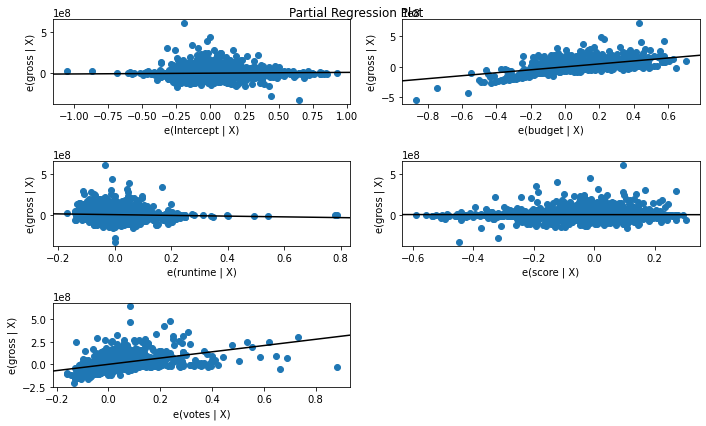

In [112]:
fig = plt.figure(figsize=(10,6))
fig = sm.graphics.plot_partregress_grid(general_model_revenue, fig=fig)

In [33]:
# Modeling for profit
y = data_profit['profit']
X = data_profit.drop(columns= ['profit', 'gross', 'company', 'country', 'genre', 'name', 'rating', 'released', 'year'])

scores = cross_val_score(lr_model, X, y, cv=10) # Cross validate
scores.mean()

0.28033078166477554

In [34]:
general_model_profit = smf.ols(formula='profit ~ budget + runtime + score + votes', data=data_profit).fit()

general_model_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     445.8
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        09:04:58   Log-Likelihood:                -87940.
No. Observations:                4638   AIC:                         1.759e+05
Df Residuals:                    4633   BIC:                         1.759e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.415e+06   3.35e+06      0.423      0.672   -5.14e+06    7.98e+06
budget     -4.852e+07   5.38e+06     -9.012      0.000   -5.91e+07    -3.8e+07
runtime    -5.223e+07   8.29e+06     -6.300      0.000   -6.85e+07    -3.6e+07
score       9.092e+06   5.77e+06      1.575      0.115   -2.22e+06    2.04e+07
votes       3.557e+08   9.81e+06     36.270      0.000    3.36e+08    3.75e+08
==============================================================================
Omnibus:                     2841.381   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           109589.260
Skew:                           2.330   Prob(JB):                         0.00
Kurtosis:                      26.353   Cond. No.                         21.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

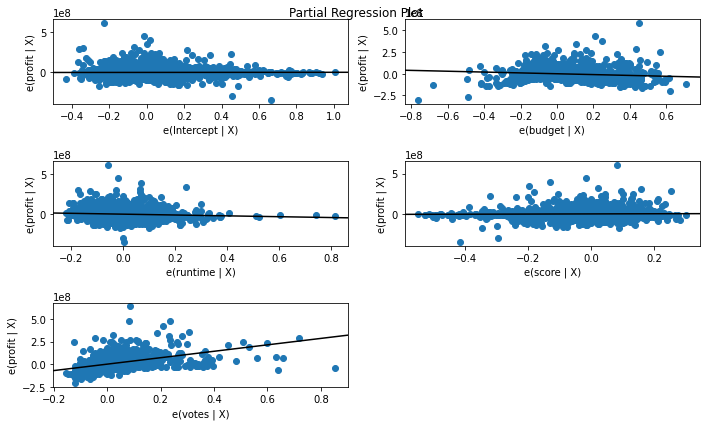

In [113]:
fig = plt.figure(figsize=(10,6))
fig = sm.graphics.plot_partregress_grid(general_model_profit, fig=fig)

#### La cantidad de votos, la cual representa la popularidad de una película, tiene un efecto positivo en los beneficios.

### ¿En qué género debería enfocarme?


In [81]:
# Evaluate correlations between genres and revenue

genre_encoding['gross']= data['gross']

genre_revenue_corr = genre_encoding.corr().tail(1).T.sort_values(by='gross', ascending = False)

genre_revenue_corr

,gross
gross,1.000000
genre_Animation,0.205038
genre_Action,0.192043
genre_Adventure,0.084048
genre_Mystery,0.003623
genre_Western,-0.007134
genre_Sci-Fi,-0.007375
genre_War,-0.009637
genre_Musical,-0.013102
genre_Fantasy,-0.015754


In [88]:
# Evaluate correlations between genres and profit

genre_encoding_profit['profit']= data_profit['profit']

genre_profit_corr = genre_encoding_profit.corr().tail(1).T.sort_values(by='profit', ascending = False)

genre_profit_corr

,profit
profit,1.000000
genre_Animation,0.101689
genre_Adventure,0.039791
genre_Horror,0.028942
genre_Comedy,0.025121
genre_Mystery,0.000516
genre_Sci-Fi,-0.002078
genre_Western,-0.002835
genre_Romance,-0.004730
genre_Musical,-0.005975


In [35]:
# Evaluate gender influence on revenue
genre_model_revenue = smf.ols(formula='gross ~ C(genre)-1', data=data).fit()

genre_model_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     50.78
Date:                Thu, 06 May 2021   Prob (F-statistic):          3.74e-153
Time:                        09:04:58   Log-Likelihood:            -1.3123e+05
No. Observations:                6820   AIC:                         2.625e+05
Df Residuals:                    6803   BIC:                         2.626e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(genre)[Action]     5.619e+07   1.51e+06     37.226      0.000    5.32e+07    5.92e+07
C(genre)[Adventure]   5.33e+07   2.78e+06     19.164      0.000    4.79e+07    5.88e+07
C(genre)[Animation]  9.149e+07   3.31e+06     27.649      0.000     8.5e+07     9.8e+07
C(genre)[Biography]    2.4e+07   2.91e+06      8.259      0.000    1.83e+07    2.97e+07
C(genre)[Comedy]     2.574e+07   1.21e+06     21.318      0.000    2.34e+07    2.81e+07
C(genre)[Crime]      1.957e+07   2.41e+06      8.121      0.000    1.48e+07    2.43e+07
C(genre)[Drama]      1.745e+07   1.45e+06     12.044      0.000    1.46e+07    2.03e+07
C(genre)[Family]     8.436e+06   1.47e+07      0.573      0.567   -2.04e+07    3.73e+07
C(genre)[Fantasy]    2.015e+07   9.74e+06      2.069      0.039    1.06e+06    3.92e+07
C(genre)[Horror]      2.57e+07   3.31e+06      7.766      0.000    1.92e+07    3.22e+07
C(genre)[Musical]    2.024e+06   2.75e+07      0.073      0.941    -5.2e+07     5.6e+07
C(genre)[Mystery]    3.631e+07   8.93e+06      4.065      0.000    1.88e+07    5.38e+07
C(genre)[Romance]    9.718e+06   1.42e+07      0.683      0.494   -1.82e+07    3.76e+07
C(genre)[Sci-Fi]     2.368e+07   1.53e+07      1.550      0.121   -6.26e+06    5.36e+07
C(genre)[Thriller]   5.533e+06    1.3e+07      0.426      0.670   -1.99e+07     3.1e+07
C(genre)[War]        7.549e+05   3.89e+07      0.019      0.985   -7.56e+07    7.71e+07
C(genre)[Western]     9.26e+06   3.89e+07      0.238      0.812   -6.71e+07    8.56e+07
==============================================================================
Omnibus:                     5929.061   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           276941.748
Skew:                           3.975   Prob(JB):                         0.00
Kurtosis:                      33.189   Cond. No.                         32.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
genre_model_revenue.params.sort_values(ascending=False)

C(genre)[Animation]    9.148810e+07
C(genre)[Action]       5.619281e+07
C(genre)[Adventure]    5.330381e+07
C(genre)[Mystery]      3.631451e+07
C(genre)[Comedy]       2.574203e+07
C(genre)[Horror]       2.569620e+07
C(genre)[Biography]    2.400425e+07
C(genre)[Sci-Fi]       2.367705e+07
C(genre)[Fantasy]      2.014541e+07
C(genre)[Crime]        1.957440e+07
C(genre)[Drama]        1.745472e+07
C(genre)[Romance]      9.717614e+06
C(genre)[Western]      9.259547e+06
C(genre)[Family]       8.436443e+06
C(genre)[Thriller]     5.533345e+06
C(genre)[Musical]      2.023748e+06
C(genre)[War]          7.548875e+05
dtype: float64

In [37]:
# Evaluate genre influence on profit
genre_model_profit = smf.ols(formula='profit ~ C(genre)-1', data=data_profit).fit()

genre_model_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.671
Date:                Thu, 06 May 2021   Prob (F-statistic):           1.08e-11
Time:                        09:04:58   Log-Likelihood:                -88653.
No. Observations:                4638   AIC:                         1.773e+05
Df Residuals:                    4622   BIC:                         1.774e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(genre)[Action]     7.183e+06   1.46e+06      4.909      0.000    4.31e+06    1.01e+07
C(genre)[Adventure]  1.744e+07   2.84e+06      6.135      0.000    1.19e+07     2.3e+07
C(genre)[Animation]  3.173e+07   3.21e+06      9.900      0.000    2.54e+07     3.8e+07
C(genre)[Biography]  7.782e+06   3.14e+06      2.480      0.013    1.63e+06    1.39e+07
C(genre)[Comedy]     1.189e+07   1.34e+06      8.868      0.000    9.26e+06    1.45e+07
C(genre)[Crime]      2.427e+06   2.57e+06      0.944      0.345   -2.61e+06    7.47e+06
C(genre)[Drama]      4.297e+06   1.72e+06      2.495      0.013     9.2e+05    7.67e+06
C(genre)[Family]     -1.17e+07   1.98e+07     -0.591      0.555   -5.05e+07    2.71e+07
C(genre)[Fantasy]    4.608e+06   9.01e+06      0.512      0.609   -1.31e+07    2.23e+07
C(genre)[Horror]     1.615e+07   3.21e+06      5.027      0.000    9.85e+06    2.24e+07
C(genre)[Musical]   -9.955e+06   4.85e+07     -0.205      0.837   -1.05e+08    8.51e+07
C(genre)[Mystery]    1.024e+07   8.71e+06      1.175      0.240   -6.84e+06    2.73e+07
C(genre)[Romance]    2.893e+06   2.17e+07      0.133      0.894   -3.96e+07    4.54e+07
C(genre)[Sci-Fi]     7.847e+06   1.46e+07      0.537      0.592   -2.08e+07    3.65e+07
C(genre)[Thriller]  -6.037e+06   1.72e+07     -0.352      0.725   -3.97e+07    2.76e+07
C(genre)[Western]     3.26e+06   3.43e+07      0.095      0.924    -6.4e+07    7.05e+07
==============================================================================
Omnibus:                     3451.583   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114663.671
Skew:                           3.202   Prob(JB):                         0.00
Kurtosis:                      26.502   Cond. No.                         36.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
genre_model_profit.params.sort_values(ascending=False)

C(genre)[Animation]    3.173390e+07
C(genre)[Adventure]    1.744454e+07
C(genre)[Horror]       1.614929e+07
C(genre)[Comedy]       1.188578e+07
C(genre)[Mystery]      1.023657e+07
C(genre)[Sci-Fi]       7.846870e+06
C(genre)[Biography]    7.781799e+06
C(genre)[Action]       7.182871e+06
C(genre)[Fantasy]      4.607509e+06
C(genre)[Drama]        4.297058e+06
C(genre)[Western]      3.259547e+06
C(genre)[Romance]      2.892564e+06
C(genre)[Crime]        2.427338e+06
C(genre)[Thriller]    -6.036880e+06
C(genre)[Musical]     -9.955243e+06
C(genre)[Family]      -1.170469e+07
dtype: float64

#### Los resultados muestran que, para maximizar los ingresos y los beneficios, debería enfocarse en el género "Animation"

### ¿Qué tan importante es producir una buena película (rating IMDB alto) para obtener muchos ingresos?

In [39]:
# Evaluate score influence on revenue

score_model_revenue = smf.ols(formula='gross ~ score', data=raw_data).fit()

score_model_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     192.5
Date:                Thu, 06 May 2021   Prob (F-statistic):           3.54e-43
Time:                        09:04:58   Log-Likelihood:            -1.3152e+05
No. Observations:                6820   AIC:                         2.630e+05
Df Residuals:                    6818   BIC:                         2.631e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.778e+07   4.47e+06     -6.213      0.000   -3.65e+07    -1.9e+07
score       9.613e+06   6.93e+05     13.873      0.000    8.25e+06     1.1e+07
==============================================================================
Omnibus:                     5884.822   Durbin-Watson:                   1.473
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           236682.896
Skew:                           3.990   Prob(JB):                         0.00
Kurtosis:                      30.735   Cond. No.                         42.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Evaluate high score influence on revenue

score_model_revenue = smf.ols(formula='gross ~ high_score', data=raw_data).fit()

score_model_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     131.5
Date:                Thu, 06 May 2021   Prob (F-statistic):           3.72e-30
Time:                        09:04:58   Log-Likelihood:            -1.3155e+05
No. Observations:                6820   AIC:                         2.631e+05
Df Residuals:                    6818   BIC:                         2.631e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.031e+07   7.51e+05     40.349      0.000    2.88e+07    3.18e+07
high_score   2.33e+07   2.03e+06     11.465      0.000    1.93e+07    2.73e+07
==============================================================================
Omnibus:                     5884.626   Durbin-Watson:                   1.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           231562.802
Skew:                           3.999   Prob(JB):                         0.00
Kurtosis:                      30.403   Cond. No.                         2.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

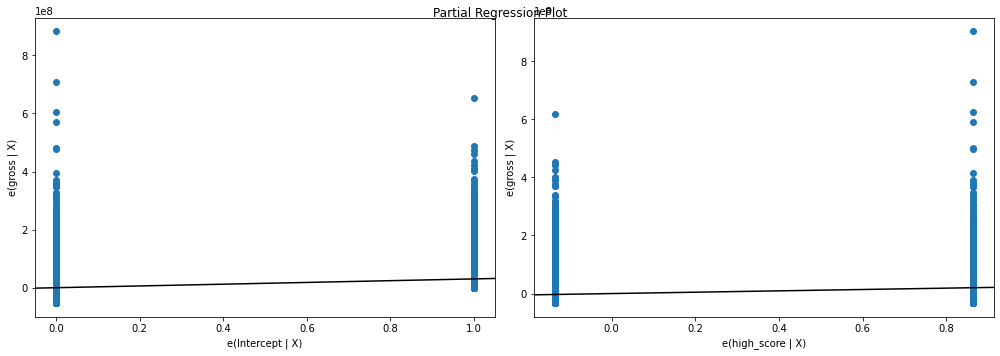

In [138]:
fig = plt.figure(figsize=(14,5))
fig = sm.graphics.plot_partregress_grid(score_model_revenue, fig=fig)

#### El score tiene un leve efecto positivo en los ingresos. Solo el 2,7% de la variación en los ingresos puede explicarse por el score. 

### ¿Es mejor producir una película para todos los públicos? ¿O una dirigida sólo al público adulto?

In [89]:
# Evaluate correlations between ratings and revenue

rating_encoding['gross']= data['gross']

rating_revenue_corr = rating_encoding.corr().tail(1).T.sort_values(by='gross', ascending = False)

rating_revenue_corr

,gross
gross,1.000000
rating_PG-13,0.203992
rating_PG,0.114873
rating_G,0.074646
rating_TV-PG,-0.006629
rating_B,-0.006897
rating_TV-14,-0.006927
rating_TV-MA,-0.006942
rating_B15,-0.006966
rating_NC-17,-0.029429


In [90]:
# Evaluate correlations between ratings and profit

rating_encoding_profit['profit']= data_profit['profit']

rating_profit_corr = rating_encoding_profit.corr().tail(1).T.sort_values(by='profit', ascending = False)

rating_profit_corr

,profit
profit,1.000000
rating_PG,0.066699
rating_G,0.062631
rating_PG-13,0.060871
rating_Not specified,-0.009250
rating_NC-17,-0.014621
rating_UNRATED,-0.016276
rating_NOT RATED,-0.028235
rating_R,-0.113297


In [42]:
# Evaluate rating influence on revenue
rating_model_revenue = smf.ols(formula='gross ~ C(rating)-1', data=data).fit()

rating_model_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     55.17
Date:                Thu, 06 May 2021   Prob (F-statistic):          1.39e-127
Time:                        09:04:58   Log-Likelihood:            -1.3130e+05
No. Observations:                6820   AIC:                         2.626e+05
Df Residuals:                    6807   BIC:                         2.627e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(rating)[B]               3.56e+05   5.56e+07      0.006      0.995   -1.09e+08    1.09e+08
C(rating)[B15]            2.084e+04   5.56e+07      0.000      1.000   -1.09e+08    1.09e+08
C(rating)[G]              6.277e+07   4.59e+06     13.685      0.000    5.38e+07    7.18e+07
C(rating)[NC-17]          3.394e+06   1.19e+07      0.286      0.775   -1.98e+07    2.66e+07
C(rating)[NOT RATED]      5.465e+05   4.22e+06      0.130      0.897   -7.72e+06    8.81e+06
C(rating)[Not specified]  1.359e+06   7.01e+06      0.194      0.846   -1.24e+07    1.51e+07
C(rating)[PG]              5.01e+07    1.8e+06     27.786      0.000    4.66e+07    5.36e+07
C(rating)[PG-13]          5.196e+07   1.24e+06     41.735      0.000    4.95e+07    5.44e+07
C(rating)[R]              1.993e+07   9.55e+05     20.869      0.000    1.81e+07    2.18e+07
C(rating)[TV-14]          2.088e+05   5.56e+07      0.004      0.997   -1.09e+08    1.09e+08
C(rating)[TV-MA]          1.362e+05   5.56e+07      0.002      0.998   -1.09e+08    1.09e+08
C(rating)[TV-PG]          1.642e+06   5.56e+07      0.030      0.976   -1.07e+08    1.11e+08
C(rating)[UNRATED]        1.056e+06    6.6e+06      0.160      0.873   -1.19e+07     1.4e+07
==============================================================================
Omnibus:                     6037.903   Durbin-Watson:                   1.360
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           278376.816
Skew:                           4.103   Prob(JB):                         0.00
Kurtosis:                      33.204   Cond. No.                         58.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# Evaluate rating influence on profit
rating_model_profit = smf.ols(formula='profit ~ C(rating)-1', data=data_profit).fit()

rating_model_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     12.18
Date:                Thu, 06 May 2021   Prob (F-statistic):           1.63e-15
Time:                        09:04:59   Log-Likelihood:                -88653.
No. Observations:                4638   AIC:                         1.773e+05
Df Residuals:                    4630   BIC:                         1.774e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(rating)[G]              3.055e+07   4.85e+06      6.303      0.000     2.1e+07       4e+07
C(rating)[NC-17]         -6.275e+06   1.62e+07     -0.388      0.698   -3.79e+07    2.54e+07
C(rating)[NOT RATED]     -5.252e+06   7.86e+06     -0.668      0.504   -2.07e+07    1.02e+07
C(rating)[Not specified] -5.456e+06   2.42e+07     -0.225      0.822    -5.3e+07    4.21e+07
C(rating)[PG]             1.794e+07   1.89e+06      9.501      0.000    1.42e+07    2.16e+07
C(rating)[PG-13]          1.411e+07   1.23e+06     11.499      0.000    1.17e+07    1.65e+07
C(rating)[R]              4.218e+06   1.02e+06      4.125      0.000    2.21e+06    6.22e+06
C(rating)[UNRATED]       -2.157e+06   1.08e+07     -0.199      0.842   -2.34e+07    1.91e+07
==============================================================================
Omnibus:                     3385.034   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           107114.457
Skew:                           3.125   Prob(JB):                         0.00
Kurtosis:                      25.698   Cond. No.                         23.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# Evaluate general rating influence on revenue
general_rating_model_revenue = smf.ols(formula='gross ~ general_movie', data=data).fit()

general_rating_model_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     38.20
Date:                Thu, 06 May 2021   Prob (F-statistic):           6.74e-10
Time:                        09:04:59   Log-Likelihood:            -1.3159e+05
No. Observations:                6820   AIC:                         2.632e+05
Df Residuals:                    6818   BIC:                         2.632e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.285e+07    7.1e+05     46.240      0.000    3.15e+07    3.42e+07
general_movie  2.991e+07   4.84e+06      6.181      0.000    2.04e+07    3.94e+07
==============================================================================
Omnibus:                     6079.965   Durbin-Watson:                   1.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           262571.722
Skew:                           4.179   Prob(JB):                         0.00
Kurtosis:                      32.226   Cond. No.                         6.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# Evaluate general rating influence on profit
general_rating_model_profit = smf.ols(formula='profit ~ general_movie', data=data_profit).fit()

general_rating_model_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     18.26
Date:                Thu, 06 May 2021   Prob (F-statistic):           1.97e-05
Time:                        09:04:59   Log-Likelihood:                -88686.
No. Observations:                4638   AIC:                         1.774e+05
Df Residuals:                    4636   BIC:                         1.774e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9.475e+06   7.24e+05     13.084      0.000    8.06e+06    1.09e+07
general_movie  2.107e+07   4.93e+06      4.273      0.000    1.14e+07    3.07e+07
==============================================================================
Omnibus:                     3468.921   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110585.982
Skew:                           3.243   Prob(JB):                         0.00
Kurtosis:                      26.025   Cond. No.                         6.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# Evaluate adult rating influence on revenue
adult_rating_model_revenue = smf.ols(formula='gross ~ adult_movie', data=data).fit()

adult_rating_model_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     387.8
Date:                Thu, 06 May 2021   Prob (F-statistic):           5.12e-84
Time:                        09:04:59   Log-Likelihood:            -1.3143e+05
No. Observations:                6820   AIC:                         2.629e+05
Df Residuals:                    6818   BIC:                         2.629e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.693e+07   9.67e+05     48.532      0.000     4.5e+07    4.88e+07
adult_movie   -2.7e+07   1.37e+06    -19.694      0.000   -2.97e+07   -2.43e+07
==============================================================================
Omnibus:                     5984.316   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           260082.984
Skew:                           4.068   Prob(JB):                         0.00
Kurtosis:                      32.139   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# Evaluate adult rating influence on profit
adult_rating_model_profit = smf.ols(formula='profit ~ adult_movie', data=data_profit).fit()

adult_rating_model_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     60.28
Date:                Thu, 06 May 2021   Prob (F-statistic):           1.00e-14
Time:                        09:04:59   Log-Likelihood:                -88665.
No. Observations:                4638   AIC:                         1.773e+05
Df Residuals:                    4636   BIC:                         1.773e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     1.53e+07   9.93e+05     15.402      0.000    1.33e+07    1.72e+07
adult_movie -1.108e+07   1.43e+06     -7.764      0.000   -1.39e+07   -8.28e+06
==============================================================================
Omnibus:                     3380.946   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           104992.843
Skew:                           3.127   Prob(JB):                         0.00
Kurtosis:                      25.454   Cond. No.                         2.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# Evaluate general and adult rating influence on revenue
general_adult_rating_model_revenue = smf.ols(formula='gross ~ general_movie + adult_movie', data=data).fit()

general_adult_rating_model_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     200.3
Date:                Thu, 06 May 2021   Prob (F-statistic):           3.10e-85
Time:                        09:04:59   Log-Likelihood:            -1.3142e+05
No. Observations:                6820   AIC:                         2.628e+05
Df Residuals:                    6817   BIC:                         2.629e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.622e+07   9.88e+05     46.799      0.000    4.43e+07    4.82e+07
general_movie  1.655e+07   4.77e+06      3.470      0.001     7.2e+06    2.59e+07
adult_movie   -2.629e+07   1.39e+06    -18.981      0.000    -2.9e+07   -2.36e+07
==============================================================================
Omnibus:                     5991.973   Durbin-Watson:                   1.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           262580.512
Skew:                           4.073   Prob(JB):                         0.00
Kurtosis:                      32.286   Cond. No.                         7.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

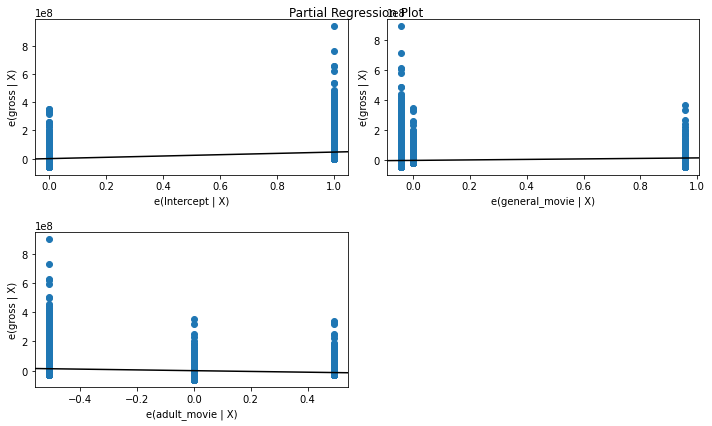

In [49]:
fig = plt.figure(figsize=(10,6))
fig = sm.graphics.plot_partregress_grid(general_adult_rating_model_revenue, fig=fig)

In [50]:
# Evaluate general and adult rating influence on profit
general_adult_rating_model_profit = smf.ols(formula='profit ~ general_movie + adult_movie', data=data_profit).fit()

general_adult_rating_model_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     35.36
Date:                Thu, 06 May 2021   Prob (F-statistic):           5.75e-16
Time:                        09:04:59   Log-Likelihood:                -88660.
No. Observations:                4638   AIC:                         1.773e+05
Df Residuals:                    4635   BIC:                         1.773e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.463e+07   1.01e+06     14.434      0.000    1.26e+07    1.66e+07
general_movie  1.592e+07   4.96e+06      3.211      0.001     6.2e+06    2.56e+07
adult_movie   -1.041e+07   1.44e+06     -7.229      0.000   -1.32e+07   -7.59e+06
==============================================================================
Omnibus:                     3387.151   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106081.945
Skew:                           3.132   Prob(JB):                         0.00
Kurtosis:                      25.576   Cond. No.                         7.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

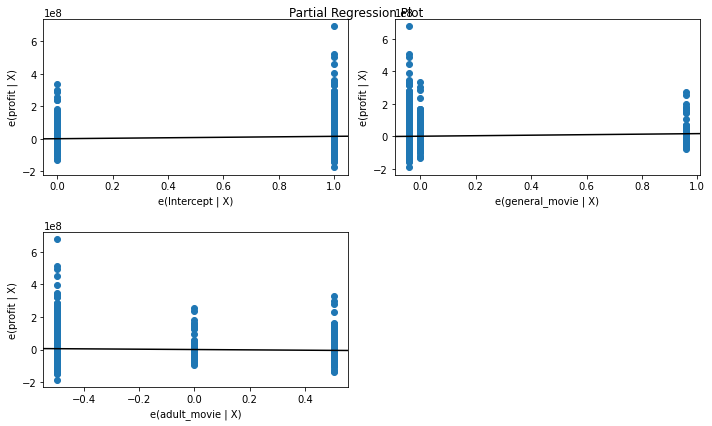

In [51]:
fig = plt.figure(figsize=(10,6))
fig = sm.graphics.plot_partregress_grid(general_adult_rating_model_profit, fig=fig)

#### Es mejor producir una película para todos los públicos porque esto tiene un leve efecto positivo en los ingresos y beneficios. Por el contrario, se observa un efecto levemente negativo si la película es clasificada para adultos.

### ...

### Analizamos la relación entre de las Companías productoras y los beneficios.

In [98]:
# Evaluate correlations between top 25 companies and revenue

company_encoding['gross']= data['gross']

company_revenue_corr = company_encoding.corr().tail(1).T.sort_values(by='gross', ascending = False)

company_revenue_corr

,gross
gross,1.000000
Walt Disney Pictures,0.146117
Warner Bros.,0.142345
Twentieth Century Fox Film Corporation,0.116894
Universal Pictures,0.114075
Paramount Pictures,0.111256
Columbia Pictures,0.105083
DreamWorks,0.069903
New Line Cinema,0.044650
Touchstone Pictures,0.042221


In [108]:
sum(company_revenue_corr['gross']**2)-1

0.10661625086352688

In [99]:
# Evaluate correlations between top 25 companies and profit

company_encoding_profit['profit']= data_profit['profit']

company_profit_corr = company_encoding_profit.corr().tail(1).T.sort_values(by='profit', ascending = False)

company_profit_corr

,profit
profit,1.000000
Twentieth Century Fox Film Corporation,0.058123
Paramount Pictures,0.054828
Walt Disney Pictures,0.053434
Universal Pictures,0.040710
New Line Cinema,0.039566
DreamWorks,0.027919
Warner Bros.,0.022355
Summit Entertainment,0.020275
Touchstone Pictures,0.019066


In [111]:
sum(company_profit_corr['profit']**2)-1

0.01687100648433404

### Analizamos la relación entre del país de origen y los beneficios.

In [100]:
# Evaluate correlations between top 15 countries and revenue

country_encoding['gross']= data['gross']

country_revenue_corr = country_encoding.corr().tail(1).T.sort_values(by='gross', ascending = False)

country_revenue_corr

,gross
gross,1.000000
USA,0.193743
China,0.008565
Germany,-0.023406
Hong Kong,-0.023765
Australia,-0.025964
Japan,-0.028210
South Korea,-0.029930
Ireland,-0.036141
Denmark,-0.038718


In [101]:
# Evaluate correlations between top 15 countries and profit

country_encoding_profit['profit']= data_profit['profit']

country_profit_corr = country_encoding_profit.corr().tail(1).T.sort_values(by='profit', ascending = False)

country_profit_corr

,profit
profit,1.000000
USA,0.105146
Japan,0.006974
Australia,0.002225
Italy,-0.013250
India,-0.015411
Hong Kong,-0.017130
Denmark,-0.017571
Canada,-0.018094
South Korea,-0.018375


#### No puedo extraer conclusiones dado que el dataset está desbalanceado, se compone en su gran mayoría de películas estadounidendes

### Analizamos la relación entre la cantidad de votos y los beneficios

In [148]:
# Evaluate votes influence on profit
votes_model_profit = smf.ols(formula='profit ~ votes', data=data_profit).fit()

votes_model_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     1569.
Date:                Fri, 07 May 2021   Prob (F-statistic):          8.45e-296
Time:                        01:55:15   Log-Likelihood:                -88019.
No. Observations:                4638   AIC:                         1.760e+05
Df Residuals:                    4636   BIC:                         1.761e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.785e+06   7.36e+05     -7.856      0.000   -7.23e+06   -4.34e+06
votes       3.062e+08   7.73e+06     39.609      0.000    2.91e+08    3.21e+08
==============================================================================
Omnibus:                     2406.000   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70758.923
Skew:                           1.898   Prob(JB):                         0.00
Kurtosis:                      21.755   Cond. No.                         12.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""